In [2]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
import time
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

In [3]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

Equation:

\begin{align}
0 = \max_e \min_{h_2} \min_{\pi_j:\sum_j^J{\pi_j}=1} &-\delta \phi(y,z_2) + \delta\eta\log e + \xi_m \frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y, z_2) e\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 - \mu_2) + \sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\sum_{j}^J \pi_{j}\left(\frac{d}{d \tau}\Lambda_j(z_2 y)\left(z_2 e-y\rho(z_2-\mu_2)+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{1}{2}\frac{d^2}{d\tau^2}\Lambda_j(z_2y)z_2y^2|\sigma_2|^2\right)\\
& + \xi_a \sum_{j}^J \pi_{j} \left(\log \pi_j - \log \pi_j^o\right)
\end{align}

where

\begin{equation}
\Lambda_j(\tau)=
\begin{cases}
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2, & \tau\leq \bar{\tau} \\
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2 + \frac{\lambda_{2,j}^+}{2}(\tau-\bar{\tau})^2, & \tau > \bar{\tau}
\end{cases}
\end{equation}

FOC of $\pi_j$ gives:
$$
\pi_j \propto \exp\left[-\frac{1}{\xi_a}(\eta-1)\left(\frac{d}{d \tau}\Lambda_j(z_2 y)\left(z_2 e-y\rho(z_2-\mu_2)+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{1}{2}\frac{d^2}{d\tau^2}\Lambda_j(z_2y)z_2y^2|\sigma_2|^2\right)\right]\pi_j^o
$$

FOC of $h_2$ gives : 

\begin{align}
h_2^* = -\frac{\frac{\partial \phi}{\partial z_2}(y, z_2)\sqrt{z_2}\sigma_2 + (\eta-1)\sum_{j}^J \pi_j \frac{d}{d \tau}\Lambda_j(z_2 y)\left(y\sqrt{z_2}\sigma_2\right)}{\xi_m}
\end{align}

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2) + (\eta-1)\sum_{j}^J\pi_j\frac{d}{d \tau}\Lambda_j(z_2 y)z_2}
$$

In [4]:
def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o  = model_paras
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat

    d_Λ = np.array([λ_1 + λ_2*y_mat*z_mat + 
                            λ_2p_j*(y_mat*z_mat>λ_bar)*(y_mat*z_mat-λ_bar) for λ_2p_j in λ_2p])
    dd_Λ = np.array([λ_2 + λ_2p_j*(y_mat*z_mat>λ_bar) for λ_2p_j in λ_2p])
    d_Λ_yz_sigma = d_Λ*y_mat*np.sqrt(z_mat)*σ_2
    d_Λ_z = d_Λ*z_mat
    mean_reversion = - y_mat*ρ*(z_mat-μ_2)
    std = np.sqrt(z_mat)*σ_2
    std_y = y_mat*std
    variance = z_mat*y_mat**2*σ_2**2

    π = np.ones_like(d_Λ)
    for i in range(π.shape[0]):
        π[i] = π_o[i]
    π_o = π.copy()
    h = - (η-1.) / ξ_m * np.sum(π*d_Λ_yz_sigma, axis=0)
    e = - δ*η / ((η-1)*np.sum(π*d_Λ_z, axis=0))
    
    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        temp = d_Λ*(z_mat*e + mean_reversion + std_y*h) + 0.5*dd_Λ*variance
        log_π_ratio = -(η-1.)*temp/ξ_a
        π_ratio = log_π_ratio - np.max(log_π_ratio, axis=0)
        π = np.exp(π_ratio) * π_o
        π = π/np.sum(π, axis=0)
        π[π<=0] = 1e-12
        
        h = - (v0_dz*std + (η-1)*np.sum(π*d_Λ_yz_sigma, axis=0)) / ξ_m
        e = - δ*η / (v0_dy + (η-1)*np.sum(π*d_Λ_z, axis=0))
        e[e<=0] = 1e-12

        A = np.ones_like(z_mat)*(-δ)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_y = e
        C_zz = z_mat*σ_2**2/2
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + ξ_m*h**2/2 + (η-1)*np.sum(π*temp, axis=0)\
            + ξ_a*np.sum(π*(np.log(π)-np.log(π_o)), axis=0)
        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    return v0, e, h, π

In [7]:
# Model parameters
η = .032
# ξ_m = .00256
# ξ_m = .05
ξ_m = 1000
ξ_a = 0.01
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/2
# Damage setting
λ_1 = 1.7675/10000
λ_2 = 0.0022*2
λ_bar = 2.

# three damage
# λ_2p = np.array([0., 0.0197*2, 0.3853*2])
# π_o = np.array([0.475, 0.475, 0.05])

# two damage
λ_2p = np.array([0., 0.0197*2])
π_o = np.array([0.5, 0.5])

pde_paras = (η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 100
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-10
y_max = 2000.
y_grid = np.linspace(y_min, y_max, n_y)

In [8]:
ϕ_grid, e_grid, h_grid, π_grid = false_transient(z_grid, y_grid, model_paras=pde_paras,
                                         v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.026943126194008515; RHS Error 0.036300287658573877
Iteration 2: LHS Error: 0.019728415020673795; RHS Error 0.026887818114799962
Iteration 3: LHS Error: 0.014247724839391518; RHS Error 0.019656860416604943
Iteration 4: LHS Error: 0.010209327914965538; RHS Error 0.014196371691642576
Iteration 5: LHS Error: 0.007347476554349752; RHS Error 0.010172589249536918
Iteration 6: LHS Error: 0.005747684392775065; RHS Error 0.007319657435692243
Iteration 7: LHS Error: 0.004845068840143463; RHS Error 0.00572419591639977
Iteration 8: LHS Error: 0.004301587003430085; RHS Error 0.004824383255473089
Iteration 9: LHS Error: 0.003961924750107371; RHS Error 0.004294423842208158
Iteration 10: LHS Error: 0.003740481767136261; RHS Error 0.003961896539511848
Iteration 11: LHS Error: 0.003592035913514313; RHS Error 0.0037437249041782535
Iteration 12: LHS Error: 0.0034885058916505063; RHS Error 0.0035986576021719927
Iteration 13: LHS Error: 0.003415825107446757; RHS Error 0.003494483089

Iteration 105: LHS Error: 0.0020763196006324813; RHS Error 0.0021084141785946246
Iteration 106: LHS Error: 0.002065978858375117; RHS Error 0.0020980222408979506
Iteration 107: LHS Error: 0.002055695483601294; RHS Error 0.0020876813378934173
Iteration 108: LHS Error: 0.002045461800855075; RHS Error 0.0020773912287775868
Iteration 109: LHS Error: 0.0020352775822514158; RHS Error 0.0020671516726094106
Iteration 110: LHS Error: 0.0020251426008434104; RHS Error 0.0020569624257185132
Iteration 111: LHS Error: 0.0020150566307015616; RHS Error 0.002046823260956461
Iteration 112: LHS Error: 0.002005019446711165; RHS Error 0.002036733937003977
Iteration 113: LHS Error: 0.0019950308247280724; RHS Error 0.002026694215595568
Iteration 114: LHS Error: 0.001985090541771206; RHS Error 0.002016703868258184
Iteration 115: LHS Error: 0.0019751983756219893; RHS Error 0.0020067626520816964
Iteration 116: LHS Error: 0.00196535410912424; RHS Error 0.0019968703423279208
Iteration 117: LHS Error: 0.00195555749

Iteration 207: LHS Error: 0.0012449170022257872; RHS Error 0.001274150851309077
Iteration 208: LHS Error: 0.001238709107186875; RHS Error 0.0012678897581695388
Iteration 209: LHS Error: 0.001232531361792466; RHS Error 0.001261659945987443
Iteration 210: LHS Error: 0.001226383645908491; RHS Error 0.0012554612576783225
Iteration 211: LHS Error: 0.001220265747268967; RHS Error 0.0012492935828176226
Iteration 212: LHS Error: 0.0012141775846729042; RHS Error 0.0012431566940851006
Iteration 213: LHS Error: 0.0012081190108731432; RHS Error 0.0012370504960462908
Iteration 214: LHS Error: 0.001202089887083757; RHS Error 0.0012309748193522103
Iteration 215: LHS Error: 0.0011960900761450732; RHS Error 0.0012249295243097862
Iteration 216: LHS Error: 0.0011901194501177659; RHS Error 0.0012189144660148532
Iteration 217: LHS Error: 0.0011841778542615589; RHS Error 0.001212929492064193
Iteration 218: LHS Error: 0.0011782651659965615; RHS Error 0.0012069744530537711
Iteration 219: LHS Error: 0.00117238

Iteration 309: LHS Error: 0.0007465846982774582; RHS Error 0.0007735697433143892
Iteration 310: LHS Error: 0.0007428520682043749; RHS Error 0.0007698171717774732
Iteration 311: LHS Error: 0.0007391376402313687; RHS Error 0.0007660833663528585
Iteration 312: LHS Error: 0.0007354413387477832; RHS Error 0.0007623682372779484
Iteration 313: LHS Error: 0.0007317630823105159; RHS Error 0.0007586716650637322
Iteration 314: LHS Error: 0.00072810280201413; RHS Error 0.0007549935871357417
Iteration 315: LHS Error: 0.0007244603701269947; RHS Error 0.000751333909062301
Iteration 316: LHS Error: 0.0007208357302374568; RHS Error 0.00074769253883087
Iteration 317: LHS Error: 0.0007172287977737224; RHS Error 0.0007440693893868595
Iteration 318: LHS Error: 0.0007136394891573417; RHS Error 0.000740464363023852
Iteration 319: LHS Error: 0.0007100677216329843; RHS Error 0.0007368773704669561
Iteration 320: LHS Error: 0.0007065134128467487; RHS Error 0.0007333083093555379
Iteration 321: LHS Error: 0.000702

Iteration 411: LHS Error: 0.0004476440461546327; RHS Error 0.0004985900736668679
Iteration 412: LHS Error: 0.00044541609814161; RHS Error 0.0004986204891137269
Iteration 413: LHS Error: 0.00044319894016925376; RHS Error 0.0004986498939622726
Iteration 414: LHS Error: 0.0004409925213758048; RHS Error 0.0004986783042233295
Iteration 415: LHS Error: 0.0004387967921644642; RHS Error 0.0004987057305534184
Iteration 416: LHS Error: 0.00043661170172856756; RHS Error 0.0004987321678526328
Iteration 417: LHS Error: 0.0004344372029432553; RHS Error 0.0004987576348221938
Iteration 418: LHS Error: 0.000432273250092291; RHS Error 0.0004987821524396821
Iteration 419: LHS Error: 0.00043011978832341313; RHS Error 0.0004988056909800698
Iteration 420: LHS Error: 0.00042797677259648337; RHS Error 0.0004988283320975645
Iteration 421: LHS Error: 0.00042584415460455993; RHS Error 0.0004988499923803888
Iteration 422: LHS Error: 0.0004237218845776214; RHS Error 0.0004988707884532213
Iteration 423: LHS Error: 

Iteration 513: LHS Error: 0.00026865913125521945; RHS Error 0.0004979205965564976
Iteration 514: LHS Error: 0.00026731410803984557; RHS Error 0.0004978881408975594
Iteration 515: LHS Error: 0.00026597566355768265; RHS Error 0.0004978553717087386
Iteration 516: LHS Error: 0.00026464376730102324; RHS Error 0.0004978222900604151
Iteration 517: LHS Error: 0.0002633244741368501; RHS Error 0.000497788896648331
Iteration 518: LHS Error: 0.0002620138188281218; RHS Error 0.0004977552067520798
Iteration 519: LHS Error: 0.00026070950941224635; RHS Error 0.0004977212147439479
Iteration 520: LHS Error: 0.0002594115158849053; RHS Error 0.0004976869272064234
Iteration 521: LHS Error: 0.00025811980938446333; RHS Error 0.0004976523490753081
Iteration 522: LHS Error: 0.0002568343601657974; RHS Error 0.0004976174782022232
Iteration 523: LHS Error: 0.0002555551405772627; RHS Error 0.000497582334374181
Iteration 524: LHS Error: 0.00025428212117274696; RHS Error 0.0004975469061164785
Iteration 525: LHS Erro

Iteration 615: LHS Error: 0.00016130119460364134; RHS Error 0.0004935718834338521
Iteration 616: LHS Error: 0.0001604966020195553; RHS Error 0.0004935236619423612
Iteration 617: LHS Error: 0.0001596959167340234; RHS Error 0.000493475408036792
Iteration 618: LHS Error: 0.000158899124627368; RHS Error 0.0004934271216355812
Iteration 619: LHS Error: 0.00015810620256460906; RHS Error 0.0004933788069647581
Iteration 620: LHS Error: 0.00015731713810261672; RHS Error 0.0004933304568341193
Iteration 621: LHS Error: 0.00015653190870191375; RHS Error 0.0004932820826873754
Iteration 622: LHS Error: 0.00015575049925315582; RHS Error 0.000493233682735017
Iteration 623: LHS Error: 0.00015497289137157005; RHS Error 0.0004931852556089369
Iteration 624: LHS Error: 0.0001541990668056728; RHS Error 0.0004931368068478784
Iteration 625: LHS Error: 0.00015342900981493018; RHS Error 0.000493088334352635
Iteration 626: LHS Error: 0.0001526627007991041; RHS Error 0.0004930398453597898
Iteration 627: LHS Error:

Iteration 717: LHS Error: 9.687649985814801e-05; RHS Error 0.0004886970086092624
Iteration 718: LHS Error: 9.639396865297484e-05; RHS Error 0.0004886513586385248
Iteration 719: LHS Error: 9.591377386479298e-05; RHS Error 0.0004886057890966418
Iteration 720: LHS Error: 9.543590580375454e-05; RHS Error 0.0004885602797658449
Iteration 721: LHS Error: 9.49603537093481e-05; RHS Error 0.0004885148389424769
Iteration 722: LHS Error: 9.448710586895497e-05; RHS Error 0.0004884694682180599
Iteration 723: LHS Error: 9.401615426935829e-05; RHS Error 0.0004884241653196203
Iteration 724: LHS Error: 9.354748710845365e-05; RHS Error 0.0004883789309092709
Iteration 725: LHS Error: 9.308109339888418e-05; RHS Error 0.0004883337578686607
Iteration 726: LHS Error: 9.261696321251692e-05; RHS Error 0.0004882886682903501
Iteration 727: LHS Error: 9.21550855539667e-05; RHS Error 0.0004882436370634742
Iteration 728: LHS Error: 9.1695452374513e-05; RHS Error 0.0004881986865280727
Iteration 729: LHS Error: 9.1238

Iteration 819: LHS Error: 5.820463496167966e-05; RHS Error 0.0004844456038744227
Iteration 820: LHS Error: 5.7914936444615484e-05; RHS Error 0.0004844083944156863
Iteration 821: LHS Error: 5.762662033275551e-05; RHS Error 0.0004843712067491568
Iteration 822: LHS Error: 5.733973432748424e-05; RHS Error 0.00048433416200180726
Iteration 823: LHS Error: 5.705440604256845e-05; RHS Error 0.000484297198625961
Iteration 824: LHS Error: 5.6770211250889435e-05; RHS Error 0.0004842603398850648
Iteration 825: LHS Error: 5.64874527823403e-05; RHS Error 0.0004842235173437952
Iteration 826: LHS Error: 5.6206220454858846e-05; RHS Error 0.0004841868271087922
Iteration 827: LHS Error: 5.592612228617205e-05; RHS Error 0.0004841502474439846
Iteration 828: LHS Error: 5.564745764993079e-05; RHS Error 0.00048411371492521754
Iteration 829: LHS Error: 5.537026058783506e-05; RHS Error 0.00048407729185732246
Iteration 830: LHS Error: 5.5094326171525876e-05; RHS Error 0.00048404092743750335
Iteration 831: LHS Err

Iteration 921: LHS Error: 3.497922910303264e-05; RHS Error 0.00048110922104895384
Iteration 922: LHS Error: 3.480516198614558e-05; RHS Error 0.00048108102935579336
Iteration 923: LHS Error: 3.4631460974848816e-05; RHS Error 0.00048105296011702325
Iteration 924: LHS Error: 3.445969141152583e-05; RHS Error 0.0004810248993497024
Iteration 925: LHS Error: 3.42877833057198e-05; RHS Error 0.0004809968984500028
Iteration 926: LHS Error: 3.411748793025193e-05; RHS Error 0.0004809690983200582
Iteration 927: LHS Error: 3.3947411745630096e-05; RHS Error 0.0004809412444290208
Iteration 928: LHS Error: 3.37783980437073e-05; RHS Error 0.00048091355701580796
Iteration 929: LHS Error: 3.360988724876446e-05; RHS Error 0.00048088598711047356
Iteration 930: LHS Error: 3.344237963480434e-05; RHS Error 0.00048085842184368566
Iteration 931: LHS Error: 3.327576073114402e-05; RHS Error 0.0004808309671449039
Iteration 932: LHS Error: 3.311097936156693e-05; RHS Error 0.00048080359569034614
Iteration 933: LHS Er

Iteration 1021: LHS Error: 2.1216102000606862e-05; RHS Error 0.0004786801358969417
Iteration 1022: LHS Error: 2.1109689954335042e-05; RHS Error 0.00047865957749302496
Iteration 1023: LHS Error: 2.100383597535005e-05; RHS Error 0.0004786390830976081
Iteration 1024: LHS Error: 2.089852190981234e-05; RHS Error 0.000478618665617072
Iteration 1025: LHS Error: 2.0793702828009186e-05; RHS Error 0.00047859830359834113
Iteration 1026: LHS Error: 2.0689395573966762e-05; RHS Error 0.0004785780148339157
Iteration 1027: LHS Error: 2.058559722079023e-05; RHS Error 0.00047855779693820044
Iteration 1028: LHS Error: 2.0482312676928238e-05; RHS Error 0.0004785376420482733
Iteration 1029: LHS Error: 2.0541753307470878e-05; RHS Error 0.00047851754776104954
Iteration 1030: LHS Error: 2.027836043301534e-05; RHS Error 0.00047849751570651355
Iteration 1031: LHS Error: 2.01759114992206e-05; RHS Error 0.000478477546831977
Iteration 1032: LHS Error: 2.0214165715071175e-05; RHS Error 0.0004784576681254732
Iterati

Iteration 1121: LHS Error: 1.2802727469424235e-05; RHS Error 0.00047693447096901903
Iteration 1122: LHS Error: 1.2737930510153816e-05; RHS Error 0.0004769199056034179
Iteration 1123: LHS Error: 1.2673444361899211e-05; RHS Error 0.0004769053945617961
Iteration 1124: LHS Error: 1.2609280793801636e-05; RHS Error 0.0004768909404309317
Iteration 1125: LHS Error: 1.2545439399769265e-05; RHS Error 0.00047687653182173356
Iteration 1126: LHS Error: 1.2481908574904499e-05; RHS Error 0.0004768621772524087
Iteration 1127: LHS Error: 1.2418699816926781e-05; RHS Error 0.0004768478720503337
Iteration 1128: LHS Error: 1.2355816285239407e-05; RHS Error 0.0004768336180458778
Iteration 1129: LHS Error: 1.2293224994464058e-05; RHS Error 0.0004768194194525073
Iteration 1130: LHS Error: 1.223094099093991e-05; RHS Error 0.0004768052665908157
Iteration 1131: LHS Error: 1.2168991466193768e-05; RHS Error 0.0004767911575461886
Iteration 1132: LHS Error: 1.2107369199654272e-05; RHS Error 0.0004767771089528479
Ite

Iteration 1221: LHS Error: 7.692644206983013e-06; RHS Error 0.00047571091222372783
Iteration 1222: LHS Error: 7.653415128622276e-06; RHS Error 0.00047570081269025094
Iteration 1223: LHS Error: 7.614404950936904e-06; RHS Error 0.00047569074431602285
Iteration 1224: LHS Error: 7.5755919847902975e-06; RHS Error 0.000475680728868208
Iteration 1225: LHS Error: 7.5377169612145245e-06; RHS Error 0.00047567072250037645
Iteration 1226: LHS Error: 7.498484669951622e-06; RHS Error 0.00047566086737961186
Iteration 1227: LHS Error: 7.460232085906848e-06; RHS Error 0.0004756508501642179
Iteration 1228: LHS Error: 7.422178403923563e-06; RHS Error 0.00047564100081697036
Iteration 1229: LHS Error: 7.38433280993156e-06; RHS Error 0.0004756311676940468
Iteration 1230: LHS Error: 7.346668671998069e-06; RHS Error 0.0004756213680663403
Iteration 1231: LHS Error: 7.309193999924246e-06; RHS Error 0.00047561160968300625
Iteration 1232: LHS Error: 7.271903089148268e-06; RHS Error 0.00047560188221949795
Iteratio

Iteration 1321: LHS Error: 4.60676686013517e-06; RHS Error 0.0004748688400516357
Iteration 1322: LHS Error: 4.5831444543675826e-06; RHS Error 0.0004748619473221895
Iteration 1323: LHS Error: 4.559641945206527e-06; RHS Error 0.00047485507900173543
Iteration 1324: LHS Error: 4.536257185036585e-06; RHS Error 0.00047484823817136104
Iteration 1325: LHS Error: 4.512989919422394e-06; RHS Error 0.0004748414248877779
Iteration 1326: LHS Error: 4.489840718061022e-06; RHS Error 0.0004748346392752893
Iteration 1327: LHS Error: 4.466805304789712e-06; RHS Error 0.0004748278764590934
Iteration 1328: LHS Error: 4.443893251993014e-06; RHS Error 0.0004748211464654824
Iteration 1329: LHS Error: 4.42108777107264e-06; RHS Error 0.0004748144315993054
Iteration 1330: LHS Error: 4.398401920416295e-06; RHS Error 0.0004748077512003075
Iteration 1331: LHS Error: 4.375829577477064e-06; RHS Error 0.0004748010929866396
Iteration 1332: LHS Error: 4.353371863524691e-06; RHS Error 0.0004747944632268082
Iteration 1333:

Iteration 1421: LHS Error: 2.750986075467088e-06; RHS Error 0.00047429748257282744
Iteration 1422: LHS Error: 2.7367976819236972e-06; RHS Error 0.00047429283676573425
Iteration 1423: LHS Error: 2.722691753123674e-06; RHS Error 0.0004742882031668373
Iteration 1424: LHS Error: 2.7086625049160817e-06; RHS Error 0.0004742835904372883
Iteration 1425: LHS Error: 2.694691390137116e-06; RHS Error 0.000474279006988574
Iteration 1426: LHS Error: 2.6807986400756434e-06; RHS Error 0.00047427442519208315
Iteration 1427: LHS Error: 2.666979125542923e-06; RHS Error 0.0004742698747813752
Iteration 1428: LHS Error: 2.653230885565905e-06; RHS Error 0.00047426533677897426
Iteration 1429: LHS Error: 2.639549365898719e-06; RHS Error 0.000474260813718045
Iteration 1430: LHS Error: 2.6259376882664665e-06; RHS Error 0.00047425631223985826
Iteration 1431: LHS Error: 2.612395373788323e-06; RHS Error 0.00047425183316528174
Iteration 1432: LHS Error: 2.5989295893147357e-06; RHS Error 0.0004742473682078155
Iterati

Iteration 1521: LHS Error: 1.6388979981740714e-06; RHS Error 0.0004739141068893747
Iteration 1522: LHS Error: 1.6304126553984277e-06; RHS Error 0.000473911008107987
Iteration 1523: LHS Error: 1.621968638371163e-06; RHS Error 0.000473907920774036
Iteration 1524: LHS Error: 1.613577165299196e-06; RHS Error 0.0004739048438158755
Iteration 1525: LHS Error: 1.6052204400429648e-06; RHS Error 0.0004739017766438175
Iteration 1526: LHS Error: 1.5969053973607927e-06; RHS Error 0.00047389872462599847
Iteration 1527: LHS Error: 1.5886357363215087e-06; RHS Error 0.00047389568327298875
Iteration 1528: LHS Error: 1.5804071220454352e-06; RHS Error 0.00047389266013773274
Iteration 1529: LHS Error: 1.5722217130975658e-06; RHS Error 0.00047388964427414956
Iteration 1530: LHS Error: 1.5640772361436017e-06; RHS Error 0.00047388664064626496
Iteration 1531: LHS Error: 1.555990856730305e-06; RHS Error 0.0004738836506955925
Iteration 1532: LHS Error: 1.5479211385588387e-06; RHS Error 0.0004738806714947759
Iter

Iteration 1620: LHS Error: 9.79048185675846e-07; RHS Error 0.0004736612489802186
Iteration 1621: LHS Error: 9.739767023592139e-07; RHS Error 0.0004736591856945478
Iteration 1622: LHS Error: 9.689241278199034e-07; RHS Error 0.00047365713164215784
Iteration 1623: LHS Error: 9.63897664824076e-07; RHS Error 0.00047365508340837734
Iteration 1624: LHS Error: 9.622305970485856e-07; RHS Error 0.0004736530467294303
Iteration 1625: LHS Error: 9.56018069792064e-07; RHS Error 0.0004736508421609789
Iteration 1626: LHS Error: 9.511226849862053e-07; RHS Error 0.0004736491502385677
Iteration 1627: LHS Error: 9.464773586265185e-07; RHS Error 0.0004736468831091807
Iteration 1628: LHS Error: 9.410360977957222e-07; RHS Error 0.0004736451641422987
Iteration 1629: LHS Error: 9.348444883899854e-07; RHS Error 0.0004736429041894315
Iteration 1630: LHS Error: 9.326816332588805e-07; RHS Error 0.00047364101797740116
Iteration 1631: LHS Error: 9.262122981912313e-07; RHS Error 0.0004736392642677584
Iteration 1632: 

Iteration 1722: LHS Error: 5.748861486021273e-07; RHS Error 0.0004734897698638746
Iteration 1723: LHS Error: 5.718766704493339e-07; RHS Error 0.0004734884209710889
Iteration 1724: LHS Error: 5.688899323841312e-07; RHS Error 0.00047348708639789044
Iteration 1725: LHS Error: 5.659165752680551e-07; RHS Error 0.0004734857501797231
Iteration 1726: LHS Error: 5.629652571337296e-07; RHS Error 0.00047348441953323425
Iteration 1727: LHS Error: 5.600283559947794e-07; RHS Error 0.00047348310253647954
Iteration 1728: LHS Error: 5.571075218646637e-07; RHS Error 0.00047348178656188983
Iteration 1729: LHS Error: 5.542029168081886e-07; RHS Error 0.00047348047284326636
Iteration 1730: LHS Error: 5.51315011518283e-07; RHS Error 0.00047347916693975256
Iteration 1731: LHS Error: 5.484447173492724e-07; RHS Error 0.0004734778669057624
Iteration 1732: LHS Error: 5.455881245119976e-07; RHS Error 0.00047347657259278614
Iteration 1733: LHS Error: 5.427470640556598e-07; RHS Error 0.0004734752860303393
Iteration 

Iteration 1824: LHS Error: 3.369500018030047e-07; RHS Error 0.00047337817234032256
Iteration 1825: LHS Error: 3.351849370558657e-07; RHS Error 0.0004733773023115305
Iteration 1826: LHS Error: 3.335777649243754e-07; RHS Error 0.0004733764309574305
Iteration 1827: LHS Error: 3.319019825642755e-07; RHS Error 0.000473375629470682
Iteration 1828: LHS Error: 3.3000707269637e-07; RHS Error 0.0004733746660135624
Iteration 1829: LHS Error: 3.2821408332828206e-07; RHS Error 0.000473373833303925
Iteration 1830: LHS Error: 3.2648748027330754e-07; RHS Error 0.00047337298774272757
Iteration 1831: LHS Error: 3.247743319556573e-07; RHS Error 0.0004733721422551171
Iteration 1832: LHS Error: 3.230883597188372e-07; RHS Error 0.0004733712986401892
Iteration 1833: LHS Error: 3.2140676858860573e-07; RHS Error 0.00047337046718035763
Iteration 1834: LHS Error: 3.1984466733470107e-07; RHS Error 0.00047336961394411556
Iteration 1835: LHS Error: 3.1821191615044597e-07; RHS Error 0.0004733688439871285
Iteration 1

Iteration 1923: LHS Error: 2.0017322784060543e-07; RHS Error 0.0004733077241206203
Iteration 1924: LHS Error: 1.9913028617701833e-07; RHS Error 0.0004733071587669953
Iteration 1925: LHS Error: 1.9807643367175665e-07; RHS Error 0.0004733065907875228
Iteration 1926: LHS Error: 1.9703160181183677e-07; RHS Error 0.00047330602281723047
Iteration 1927: LHS Error: 1.9600137242392623e-07; RHS Error 0.00047330546047617134
Iteration 1928: LHS Error: 1.9496665681906222e-07; RHS Error 0.00047330489951695476
Iteration 1929: LHS Error: 1.9394967877561786e-07; RHS Error 0.0004733043476014033
Iteration 1930: LHS Error: 1.9292243388924213e-07; RHS Error 0.0004733037893366633
Iteration 1931: LHS Error: 1.9190962004256296e-07; RHS Error 0.0004733032398909799
Iteration 1932: LHS Error: 1.908980567788543e-07; RHS Error 0.0004733026864504053
Iteration 1933: LHS Error: 1.8989375556721644e-07; RHS Error 0.00047330214369410706
Iteration 1934: LHS Error: 1.8889838485081079e-07; RHS Error 0.0004733015965997685
I

Iteration 2022: LHS Error: 1.1882036889121483e-07; RHS Error 0.0004732619330334066
Iteration 2023: LHS Error: 1.1900806282105769e-07; RHS Error 0.0004732614111837216
Iteration 2024: LHS Error: 1.1759782526932216e-07; RHS Error 0.0004732608944155968
Iteration 2025: LHS Error: 1.1677688474542869e-07; RHS Error 0.00047326063036048915
Iteration 2026: LHS Error: 1.1765646794337226e-07; RHS Error 0.000473260346546555
Iteration 2027: LHS Error: 1.1629925050771206e-07; RHS Error 0.0004732607825260436
Iteration 2028: LHS Error: 1.155113664164098e-07; RHS Error 0.0004732593622173778
Iteration 2029: LHS Error: 1.1572297377304697e-07; RHS Error 0.00047325959607911333
Iteration 2030: LHS Error: 1.140442287272947e-07; RHS Error 0.0004732585439471901
Iteration 2031: LHS Error: 1.1425566968925605e-07; RHS Error 0.00047325840112366624
Iteration 2032: LHS Error: 1.1352992514146454e-07; RHS Error 0.0004732579571731649
Iteration 2033: LHS Error: 1.1262088467356435e-07; RHS Error 0.00047325842688222125
Ite

Iteration 2123: LHS Error: 6.955830395005691e-08; RHS Error 0.00047323153154121486
Iteration 2124: LHS Error: 6.919790715431695e-08; RHS Error 0.0004732313029810892
Iteration 2125: LHS Error: 6.882443187583576e-08; RHS Error 0.00047323105470662916
Iteration 2126: LHS Error: 6.847703283574536e-08; RHS Error 0.0004732308386510564
Iteration 2127: LHS Error: 6.809831959442292e-08; RHS Error 0.0004732305941183221
Iteration 2128: LHS Error: 6.774672055287478e-08; RHS Error 0.0004732303591849542
Iteration 2129: LHS Error: 6.737844124304893e-08; RHS Error 0.0004732301182193005
Iteration 2130: LHS Error: 6.703776758709701e-08; RHS Error 0.00047322989809369526
Iteration 2131: LHS Error: 6.666610455341448e-08; RHS Error 0.00047322966248360826
Iteration 2132: LHS Error: 6.631965655812255e-08; RHS Error 0.00047322943723882016
Iteration 2133: LHS Error: 6.596253146473607e-08; RHS Error 0.000473229197278862
Iteration 2134: LHS Error: 6.56297572260156e-08; RHS Error 0.00047322898195750404
Iteration 21

Iteration 2223: LHS Error: 4.086294153049508e-08; RHS Error 0.00047321228653133054
Iteration 2224: LHS Error: 4.1358701852178825e-08; RHS Error 0.00047321212279407415
Iteration 2225: LHS Error: 4.059995177552178e-08; RHS Error 0.00047321257144987416
Iteration 2226: LHS Error: 4.055151700543824e-08; RHS Error 0.00047321204781600873
Iteration 2227: LHS Error: 4.051352732459268e-08; RHS Error 0.0004732113695134557
Iteration 2228: LHS Error: 3.9696975526193334e-08; RHS Error 0.00047321184207906736
Iteration 2229: LHS Error: 4.000219677724459e-08; RHS Error 0.00047321141681286316
Iteration 2230: LHS Error: 3.957668746890075e-08; RHS Error 0.0004732109194678681
Iteration 2231: LHS Error: 4.0155226990745696e-08; RHS Error 0.0004732108867665022
Iteration 2232: LHS Error: 3.890745729762113e-08; RHS Error 0.0004732113398759098
Iteration 2233: LHS Error: 3.8597021773112417e-08; RHS Error 0.0004732109362266812
Iteration 2234: LHS Error: 3.9118486047651224e-08; RHS Error 0.0004732106361718426
Itera

Iteration 2323: LHS Error: 2.4712577220697973e-08; RHS Error 0.00047319984384006086
Iteration 2324: LHS Error: 2.4170016710289843e-08; RHS Error 0.0004731997743811049
Iteration 2325: LHS Error: 2.4269025455936344e-08; RHS Error 0.00047319970053858254
Iteration 2326: LHS Error: 2.3971737359018697e-08; RHS Error 0.0004731996188704485
Iteration 2327: LHS Error: 2.4709225859842476e-08; RHS Error 0.0004731995327311861
Iteration 2328: LHS Error: 4.5251227084874834e-08; RHS Error 0.00047319941283944025
Iteration 2329: LHS Error: 3.458314357107639e-08; RHS Error 0.00047319924519930584
Iteration 2330: LHS Error: 2.857595284011527e-08; RHS Error 0.00047319913485474943
Iteration 2331: LHS Error: 2.5583472548773578e-08; RHS Error 0.0004731989818019221
Iteration 2332: LHS Error: 2.4114485103199357e-08; RHS Error 0.0004731989066332834
Iteration 2333: LHS Error: 2.34715080843495e-08; RHS Error 0.0004731988933191593
Iteration 2334: LHS Error: 2.2928996215587638e-08; RHS Error 0.0004731988268834586
Ite

Iteration 2422: LHS Error: 4.189213724525853e-08; RHS Error 0.00047319143856761753
Iteration 2423: LHS Error: 1.6163745800157336e-08; RHS Error 0.00047319176195567345
Iteration 2424: LHS Error: 4.1434541089846455e-08; RHS Error 0.0004731913229546539
Iteration 2425: LHS Error: 1.598193018204075e-08; RHS Error 0.0004731916426952802
Iteration 2426: LHS Error: 4.0983352184165156e-08; RHS Error 0.00047319120775561607
Iteration 2427: LHS Error: 1.5804753339399014e-08; RHS Error 0.00047319152667881295
Iteration 2428: LHS Error: 4.053941453363574e-08; RHS Error 0.00047319109416386895
Iteration 2429: LHS Error: 1.5631647129477066e-08; RHS Error 0.0004731914104698122
Iteration 2430: LHS Error: 4.0102954831922055e-08; RHS Error 0.00047319098112596006
Iteration 2431: LHS Error: 1.5462157332279958e-08; RHS Error 0.00047319129424603507
Iteration 2432: LHS Error: 3.9673817398000466e-08; RHS Error 0.0004731908702275481
Iteration 2433: LHS Error: 1.529593429694387e-08; RHS Error 0.0004731911808121929
I

In [9]:
np.save('y_mid.npy', y_grid)
np.save('pi_mid.npy', π_grid)

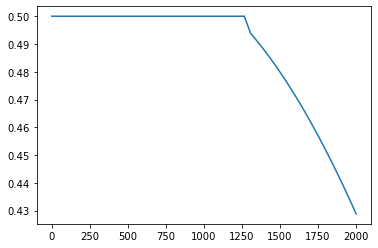

In [179]:
plt.plot(y_grid, π_grid[0,25])

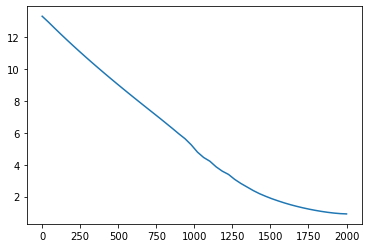

In [162]:
plt.plot(y_grid, e_grid[25])

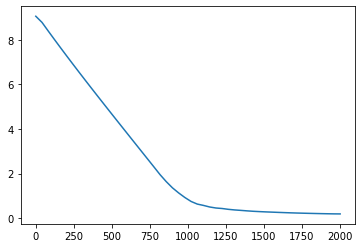

In [156]:
plt.plot(y_grid, e_grid[25])

In [150]:
@njit(parallel=True)
def simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_h(e_grid, y_grid, h_grid, y_start=290, z_loc=25, T=100):
    ht = np.zeros(T+1)
    for i in range(T+1):
        e = np.interp(y_start, y_grid, e_grid[z_loc])
        ht[i] = np.interp(y_start, y_grid, h_grid[z_loc])
        y_start = y_start + e
    return ht


@njit(parallel=True)
def simulate_π(e_grid, y_grid, π_grid, y_start=290, z_loc=25, T=100):
    πt = np.zeros(T+1)
    for i in range(T+1):
        e = np.interp(y_start, y_grid, e_grid[z_loc])
        πt[i] = np.interp(y_start, y_grid, π_grid[0, z_loc])
        y_start = y_start + e
    return πt


@njit(parallel=True)
def simulate_damage(e_grid, y_grid, λ_1, λ_2, λ_2p, λ_bar, y_start=290, z_loc=25, T=100):
    nt = np.zeros(T+1)
    for i in range(T+1):
        e = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + e
        nt[i] = 1./np.exp(λ_1*μ_2*y_start + 0.5*λ_2*(μ_2*y_start)**2 + 0.5*λ_2p*(μ_2*y_start-λ_bar)**2*(μ_2*y_start>λ_bar))
    return nt


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [153]:
T = 100
Et = simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=T)
ht = simulate_h(e_grid, y_grid, h_grid, y_start=290, z_loc=25, T=T)
πt = simulate_π(e_grid, y_grid, π_grid, y_start=290, z_loc=25, T=T)
nt_low = simulate_damage(e_grid, y_grid, λ_1, λ_2, λ_2p[0], λ_bar, y_start=290, z_loc=25, T=100)
nt_high = simulate_damage(e_grid, y_grid, λ_1, λ_2, λ_2p[1], λ_bar, y_start=290, z_loc=25, T=100)

Text(0.5, 0, 'Year')

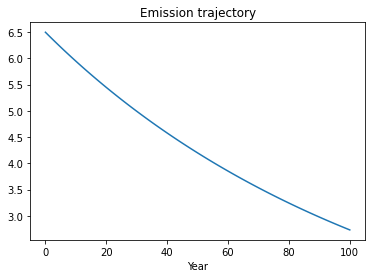

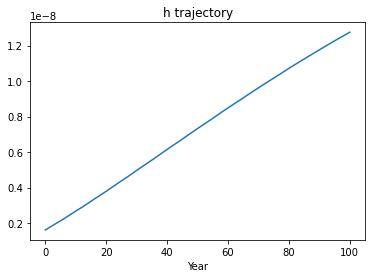

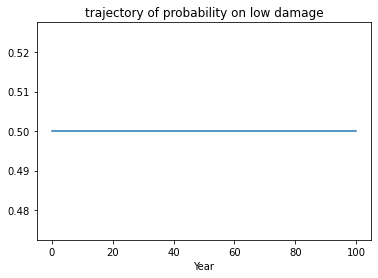

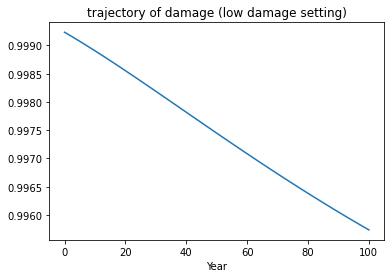

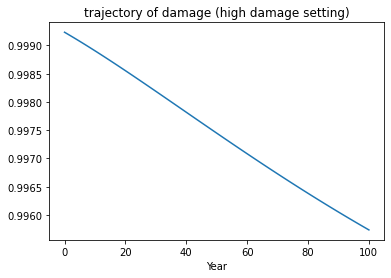

In [154]:
plt.figure()
plt.title('Emission trajectory')
plt.plot(Et)
plt.xlabel('Year')
plt.figure()
plt.title('h trajectory')
plt.plot(ht)
plt.xlabel('Year')
plt.figure()
plt.title('trajectory of probability on low damage')
plt.plot(πt)
plt.xlabel('Year')
plt.figure()
plt.title('trajectory of damage (low damage setting)')
plt.plot(nt_low)
plt.xlabel('Year')
plt.figure()
plt.title('trajectory of damage (high damage setting)')
plt.plot(nt_high)
plt.xlabel('Year')

In [ ]:
T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [ ]:
SCCt = η*(α-ioverk)*Kt/((1.-η)*Et)
# SCCt = η*(0.025)*Kt/((1.-η)*Et)

In [ ]:
plt.plot(SCCt[:21]*1000)
plt.ylim(0, None)
plt.title('Figure 1: Social cost of carbon')
plt.xlabel('Year')
# plt.savefig('figure_1.pdf')

In [ ]:
import pickle
with open('scc_bhh.pkl', 'rb') as f:
    scc_bhh = pickle.load(f)
with open('emission.pkl', 'rb') as f:
    emission_bbh = pickle.load(f)

In [ ]:
plt.plot(scc_bhh[0]['x'], scc_bhh[0]['y'])

In [ ]:
scc_low = np.array([scc_bhh[0]['y'][4*i] for i in range(21)])

### SCC formula

$$
SCC = \frac{\eta\left[\color{red}{\alpha - \left(\frac{i}{k}\right)^*}\right]K_t^*}{(1-\eta)E_t^*}
$$

(1) in BBH, $\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.025$.

(2) in the new paper, $\alpha=0.2, \left(\frac{i}{k}\right)^*=0.125$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.075$.

### Adjustment cost parameters

$\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$

From FOC of $\frac{i}{k}$, we have:
$$
1-\kappa \left(\frac{i}{k}\right)^* - \frac{\delta}{\alpha-\left(\frac{i}{k}\right)^*} = 0 
$$

Therefore $\kappa=6.667$

### Log damage evolution

$$
d\log N_t = \left[\frac{d}{d\tau}\Lambda(Z_{2,t} F_t)[E_tZ_t-\rho(Z_{2,t}-\mu_2)F_t]+\frac{1}{2}\frac{d^2}{d\tau^2}\Lambda(Z_{2,t}F_t)Z_{2,t}F_t^2\sigma_2^2\right]dt + \frac{d}{d\tau} \Lambda(Z_{2,t}F_t)F_t\sqrt{Z_{2,t}}\sigma_zdW_t
$$

where

$$
dZ_t^2 = -\rho(Z_t^2 - \mu_2) dt + \sqrt{Z_t^2}\sigma_2 d W_{2,t}
$$

$$
\Lambda(\tau) = \lambda_1 \tau + \frac{\lambda_2}{2} \tau^2
$$

In [ ]:
(1-δ/(α-ioverk))/ioverk

In [ ]:
-0.0429 + ioverk - κ/2.*ioverk**2

In [ ]:
plt.plot(SCCt[:21]*1000, label='new')
plt.plot(scc_low, label='BBH low damage')
plt.ylim(0, 150)
plt.xlabel('Year')
plt.legend()
plt.title('SCC comparison')
plt.savefig('scc.pdf')

In [ ]:
plt.plot(Et[:21], label='new')
plt.plot(emission_low, label='BBH low damage')
plt.ylim(0, 20)
plt.xlabel('Year')
plt.legend()
plt.title('Emission comparison')
plt.savefig('emission.pdf')

In [ ]:
emission_low = np.array([emission_bbh[0]['y'][4*i] for i in range(21)])